<a href="https://colab.research.google.com/github/VinamrJain/CT_image_enhancement/blob/main/CT_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import PIL.ImageOps
from skimage.transform import radon, rescale, iradon
from IPython.display import clear_output

In [ ]:
from skimage.transform import iradon_sart
from skimage import restoration
from skimage.restoration import denoise_nl_means
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, calibrate_denoiser)
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
import torch
torch.cuda.is_available()

True

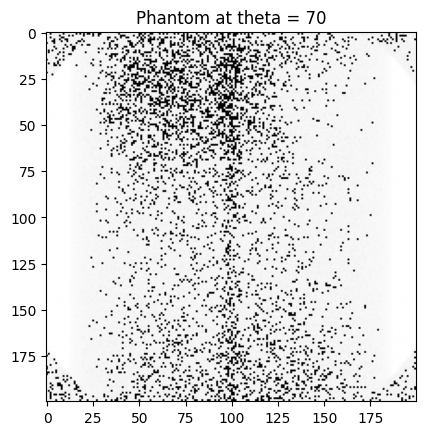

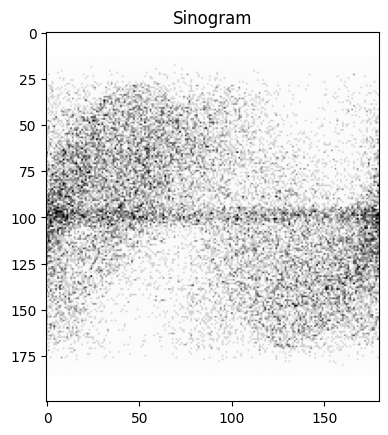

In [ ]:
''' root = Tk()
files = filedialog.askopenfilenames()

image_stack = []
for file in files:

    raw_data = np.fromfile(file, dtype=np.int32)
    image_height = 200
    image_width = 200
    raw_data = raw_data.reshape((image_height, image_width))
    image_stack.append(raw_data) '''
# Path to the directory containing .dat files
dat_directory = Path("/content/drive/MyDrive/Image_data/Outputs/160kV - new deg")

# Loop through .dat files
image_stack = []
for idx, dat_file in enumerate(dat_directory.glob("*.dat")):
    # Load .dat file as raw data
    raw_data = np.fromfile(dat_file, dtype=np.int32)
    image_height = 200  # Provide the image height
    image_width = 200   # Provide the image width
    raw_data = raw_data.reshape((image_height, image_width))  # Adjust dimensions as needed
    #raw_data = raw_data.byteswap()
    #normalized_data = ((raw_data - np.min(raw_data)) / (np.max(raw_data) - np.min(raw_data))) * 255
    #normalized_data = normalized_data.astype('int32')
    image_stack.append(raw_data)


image_stack = np.stack(image_stack,axis=0)

sinogram=[]
mid_slice= 40
slice_thickness = 2

for i in range(0,180):
    col = np.sum(image_stack[i, mid_slice-slice_thickness:mid_slice+slice_thickness, :], axis = 0, dtype='int64')
    #col = image_stack[i, 70, :]
    sinogram.append(col)

plt.imshow(image_stack[mid_slice],cmap='gray')
plt.title(f'Phantom at theta = {70}')
plt.savefig(f'Phantom at theta = {70} og', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()


sinogram = np.array(sinogram).T
plt.imshow(sinogram,cmap=plt.cm.Greys_r)
plt.title("Sinogram")
plt.savefig('Sinogram', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

theta = np.arange(0,360,2)

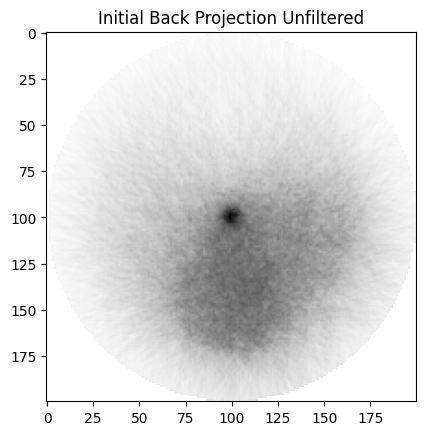

In [ ]:
back_projection_unfiltered = iradon(sinogram, theta, filter_name=None)

back_projection_unfiltered[back_projection_unfiltered==0] = np.nan
#back_projection_unfiltered = ((back_projection_unfiltered - np.min(back_projection_unfiltered)) / (np.max(back_projection_unfiltered) - np.min(back_projection_unfiltered))) * 255
#back_projection_unfiltered = back_projection_unfiltered.astype('float32')
plt.imshow(back_projection_unfiltered,cmap=plt.cm.Greys_r)
plt.title("Initial Back Projection Unfiltered")
plt.savefig('Initial Back Projection Unfiltered', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

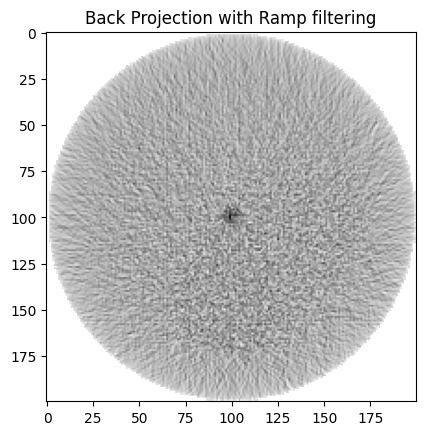

In [ ]:
back_projection_filtered = iradon(sinogram, theta, filter_name='ramp')

back_projection_filtered[back_projection_filtered==0] = np.nan
plt.imshow(back_projection_filtered,cmap=plt.cm.Greys_r)
plt.title("Back Projection with Ramp filtering")
plt.savefig('Back Projection with Ramp filtering', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

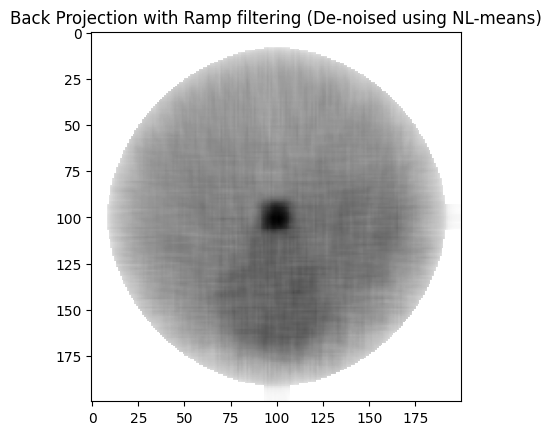

In [ ]:
reconstructed_image_denoised = denoise_nl_means(back_projection_filtered, patch_size=5, patch_distance=7)
reconstructed_image_denoised[reconstructed_image_denoised==0] = np.nan
plt.imshow(reconstructed_image_denoised,cmap=plt.cm.Greys_r)
plt.title("Back Projection with Ramp filtering (De-noised using NL-means)")
plt.savefig("Back Projection with Ramp filtering (De-noised using NL-means)", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

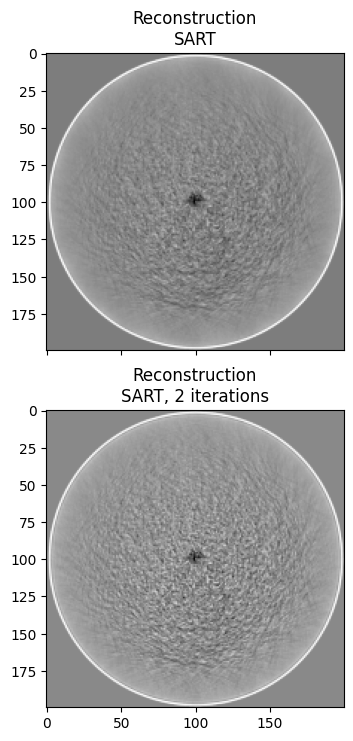

' reconstruction_sart2_denoised = denoise_nl_means(reconstruction_sart2)\nax[2].set_title("Reconstruction\nSART, 2 iterations, De-noised")\nax[2].imshow(reconstruction_sart2_denoised, cmap=plt.cm.Greys_r) \nplt.show() '

In [ ]:
reconstruction_sart = iradon_sart(sinogram, theta=theta)

fig, axes = plt.subplots(2, 1, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)

ax[1].set_title("Reconstruction\nSART, 2 iterations")
ax[1].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)
plt.savefig("Reconstruction SART", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
#De-noised
''' reconstruction_sart2_denoised = denoise_nl_means(reconstruction_sart2)
ax[2].set_title("Reconstruction\nSART, 2 iterations, De-noised")
ax[2].imshow(reconstruction_sart2_denoised, cmap=plt.cm.Greys_r)
plt.show() '''

In [ ]:
''' fig, axes = plt.subplots(4, 1, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(back_projection_filtered,cmap=plt.cm.Greys_r)
ax[0].set_title('FBP')
ax[1].imshow(denoise_tv_chambolle(back_projection_filtered),cmap=plt.cm.Greys_r)
ax[1].set_title('TV')
ax[2].imshow(denoise_bilateral(back_projection_filtered),cmap=plt.cm.Greys_r)
ax[2].set_title('Bilateral')
ax[3].imshow(denoise_wavelet(back_projection_filtered),cmap=plt.cm.Greys_r)
ax[3].set_title('Wavelet denoising')
fig.tight_layout()

plt.show() '''

" fig, axes = plt.subplots(4, 1, figsize=(8, 8.5), sharex=True, sharey=True)\nax = axes.ravel()\n\nax[0].imshow(back_projection_filtered,cmap=plt.cm.Greys_r)\nax[0].set_title('FBP')\nax[1].imshow(denoise_tv_chambolle(back_projection_filtered),cmap=plt.cm.Greys_r)\nax[1].set_title('TV')\nax[2].imshow(denoise_bilateral(back_projection_filtered),cmap=plt.cm.Greys_r)\nax[2].set_title('Bilateral')\nax[3].imshow(denoise_wavelet(back_projection_filtered),cmap=plt.cm.Greys_r)\nax[3].set_title('Wavelet denoising')\nfig.tight_layout()\n\nplt.show() "

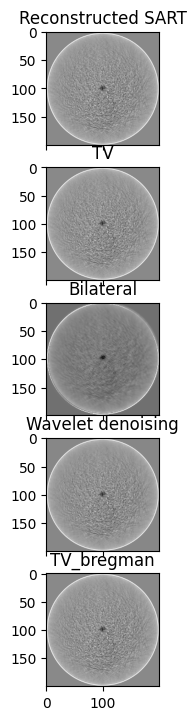

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(reconstruction_sart2,cmap=plt.cm.Greys_r)
ax[0].set_title('Reconstructed SART')
ax[1].imshow(denoise_tv_chambolle(reconstruction_sart2),cmap=plt.cm.Greys_r)
ax[1].set_title('TV')
ax[2].imshow(denoise_bilateral(reconstruction_sart2),cmap=plt.cm.Greys_r)
ax[2].set_title('Bilateral')
ax[3].imshow(denoise_wavelet(reconstruction_sart2),cmap=plt.cm.Greys_r)
ax[3].set_title('Wavelet denoising')
ax[4].imshow(denoise_tv_bregman(reconstruction_sart2),cmap=plt.cm.Greys_r)
ax[4].set_title('TV_bregman')
plt.savefig("SART with different denoising", bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
''' reconstruction_sartx = iradon_sart(sinogram, theta=theta,image=back_projection_filtered)
reconstruction_sartx2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sartx)
#reconstruction_sartx2_denoised = denoise_tv_chambolle(reconstruction_sartx2)
plt.imshow(reconstruction_sartx2,cmap=plt.cm.Greys_r)

plt.title("FBP+ SART (2 Iterations)") '''

' reconstruction_sartx = iradon_sart(sinogram, theta=theta,image=back_projection_filtered)\nreconstruction_sartx2 = iradon_sart(sinogram, theta=theta,\n                                   image=reconstruction_sartx)\n#reconstruction_sartx2_denoised = denoise_tv_chambolle(reconstruction_sartx2)\nplt.imshow(reconstruction_sartx2,cmap=plt.cm.Greys_r)\n\nplt.title("FBP+ SART (2 Iterations)") '

Minimum self-supervised loss TV: 476205755015505.6875


Text(0.5, 1.0, 'SART (2 Iterations) + de-noise TV (calibrated)')

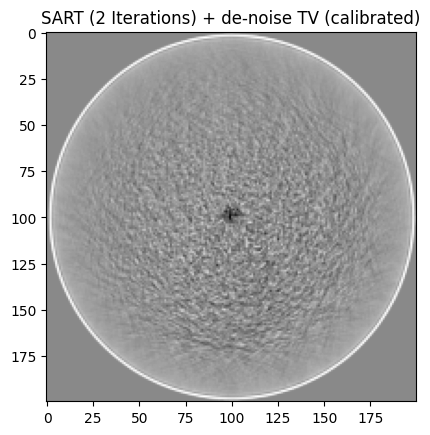

In [ ]:
parameter_ranges_tv = {'weight': np.arange(0.01, 0.3, 0.02)}
_, (parameters_tested_tv, losses_tv) = calibrate_denoiser(
                                    reconstruction_sart2,
                                    denoise_tv_chambolle,
                                    denoise_parameters=parameter_ranges_tv,
                                    extra_output=True)
print(f'Minimum self-supervised loss TV: {np.min(losses_tv):.4f}')

best_parameters_tv = parameters_tested_tv[np.argmin(losses_tv)]
''' denoised_calibrated_tv = denoise_invariant(reconstruction_sart2, denoise_tv_chambolle,
                                           denoiser_kwargs=best_parameters_tv) '''
denoised_default_tv = denoise_tv_chambolle(reconstruction_sart2, **best_parameters_tv)
plt.imshow(denoised_default_tv,cmap=plt.cm.Greys_r)
plt.savefig("SART (2 Iterations) + de-noise TV (calibrated)", bbox_inches='tight', pad_inches=0, dpi=300)
plt.title("SART (2 Iterations) + de-noise TV (calibrated)")

Text(0.5, 1.0, 'SART (2 Iterations) + de-noise TV (calibrated) rescaled')

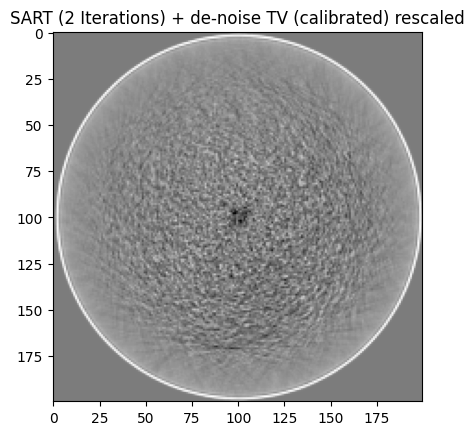

In [ ]:
normalized_denoised_default_tv = ((denoised_default_tv - np.min(denoised_default_tv)) / (np.max(denoised_default_tv) - np.min(denoised_default_tv))) * 255
normalized_denoised_default_tv = normalized_denoised_default_tv.astype('float32')
plt.imshow(normalized_denoised_default_tv,cmap=plt.cm.Greys_r)
plt.title("SART (2 Iterations) + de-noise TV (calibrated) rescaled")

In [ ]:
''' psnr_sart = psnr(normalized_denoised_default_tv,back_projection_unfiltered)
print(psnr_sart) '''

' psnr_sart = psnr(normalized_denoised_default_tv,back_projection_unfiltered)\nprint(psnr_sart) '

In [ ]:
# Path to the directory containing .dat files
dat_directory = Path("/content/drive/MyDrive/Image_data/Outputs/160kV - new deg")

# Loop through .dat files
image_stack = []
for idx, dat_file in enumerate(dat_directory.glob("*.dat")):
    # Load .dat file as raw data
    raw_data = np.fromfile(dat_file, dtype=np.float32)
    image_height = 200  # Provide the image height
    image_width = 200   # Provide the image width
    raw_data = raw_data.reshape((image_height, image_width))  # Adjust dimensions as needed
    raw_data = raw_data.byteswap()
    normalized_data = ((raw_data - np.min(raw_data)) / (np.max(raw_data) - np.min(raw_data))) * 255
    normalized_data = normalized_data.astype('float32')
    image_stack.append(normalized_data)

In [ ]:
image_stack = np.stack(image_stack,axis=0)

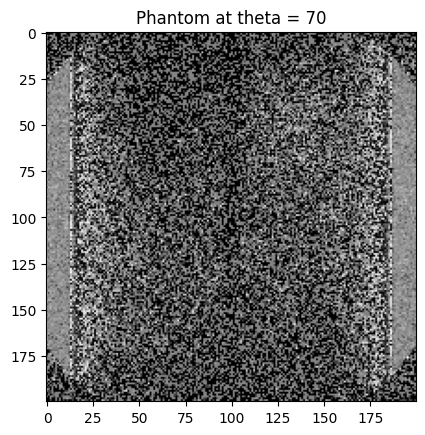

In [ ]:
num_slices, rows, columns = image_stack.shape

#the angles for which projections were taken (0 to 180 degrees)
#theta = np.arange(0, 180, 1)
#for i in theta:
#clear_output(wait=True)
plt.imshow(image_stack[70],cmap='gray')
plt.title(f'Phantom at theta = {70}')
plt.savefig(f'Phantom at theta = {70} (different byte ordering)', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

#ROUGH WORK BELOW

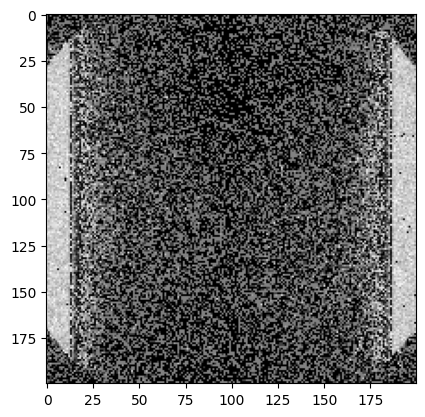

Mean: 2.9388031393820064e-41
Minimum: 0.0
Maximum: 9.121051704290234e-41


In [ ]:
# Path to the directory containing .dat files
dat_path = Path("/content/drive/MyDrive/Image_data/Outputs/100kV - new deg/benchmarkCT_000.dat")
# Load .dat file as raw data
raw_data = np.fromfile(dat_path, dtype=np.float32)
image_height = 200  # Provide the image height
image_width = 200   # Provide the image width
raw_data = raw_data.reshape((image_height, image_width))  # Adjust dimensions as needed
#normalize the data
#normalized_data = ((raw_data - np.min(raw_data)) / (np.max(raw_data) - np.min(raw_data))) * 255
#normalized_data = normalized_data.astype('int32')

# Convert the normalized data to a PIL Image
#pil_image = Image.fromarray(normalized_data)
#plt.imshow(raw_data)
#plt.show()
# Convert to PIL Image
#pil_image = Image.fromarray(raw_data.astype(np.float32))

# Convert the raw_data to big-endian byte order
big_endian_data = raw_data.byteswap()

# Plot the big-endian data using matplotlib
plt.imshow(big_endian_data, cmap='gray')
plt.show()
# Invert the image if needed (since PIL uses 0 for black and 255 for white)
#inverted_image = Image.eval(pil_image, lambda x: np.max(raw_data) - x)
#inverted_image = PIL.ImageOps.invert(pil_image)
#output_filename = f"image_{idx:03d}.jpg"
#pil_image.save(output_filename)
# Display the image in Jupyter Notebook

#display(pil_image)
print(f'Mean: {big_endian_data.mean()}')
print(f'Minimum: {big_endian_data.min()}')
print(f'Maximum: {big_endian_data.max()}')

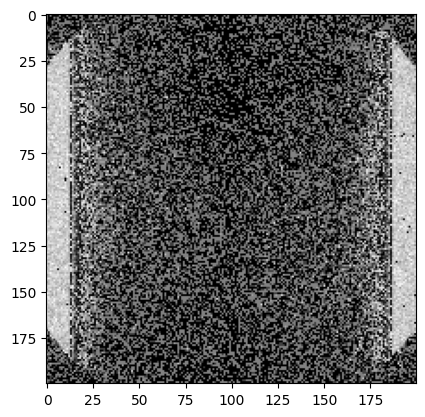

Mean: 82.162353515625
Minimum: 0.0
Maximum: 255.0


In [ ]:
normalized_data = ((big_endian_data - np.min(big_endian_data)) / (np.max(big_endian_data) - np.min(big_endian_data))) * 255
normalized_data = normalized_data.astype('float32')
plt.imshow(normalized_data, cmap='gray')
plt.show()
print(f'Mean: {normalized_data.mean()}')
print(f'Minimum: {normalized_data.min()}')
print(f'Maximum: {normalized_data.max()}')

In [ ]:
sinogram = []
for i in range (0,180):
  sinogram.append(image_stack[i][70]) #Take the 70th row from each image in stack to create sinogram
sinogram = np.array(sinogram).T
sinogram.shape

(200, 180)

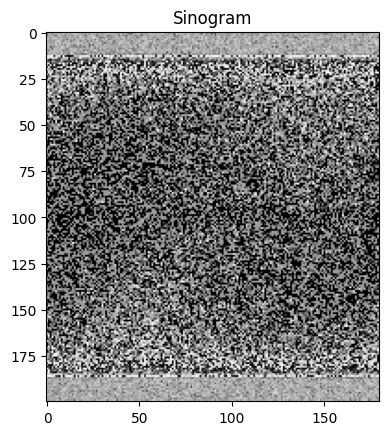

In [ ]:
plt.imshow(sinogram,cmap=plt.cm.Greys_r)
plt.title("Sinogram")
plt.show()

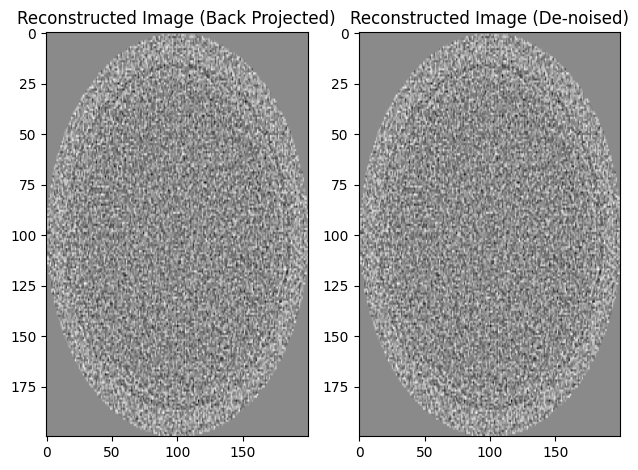

In [ ]:
for j in range (0,180):
  clear_output(wait=True)
  sinogram = []
  for i in range (0,180):
    sinogram.append(image_stack[i][j]) #Take the jth row from each image in stack to create sinogram
  sinogram = np.array(sinogram).T
  theta = np.arange(0,180,1)
  reconstructed_image_fbp = iradon(sinogram, theta=theta, circle=True,filter_name='ramp')
  reconstructed_image_denoised = denoise_nl_means(reconstructed_image_fbp, patch_size=5, patch_distance=7)
  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.set_title("Reconstructed Image (Back Projected)")
  ax1.imshow(reconstructed_image_fbp,cmap=plt.cm.Greys_r, aspect = 'auto')
  ax2.set_title("Reconstructed Image (De-noised)")
  ax2.imshow(reconstructed_image_denoised,cmap=plt.cm.Greys_r, aspect = 'auto')
  fig.tight_layout()
  plt.show()

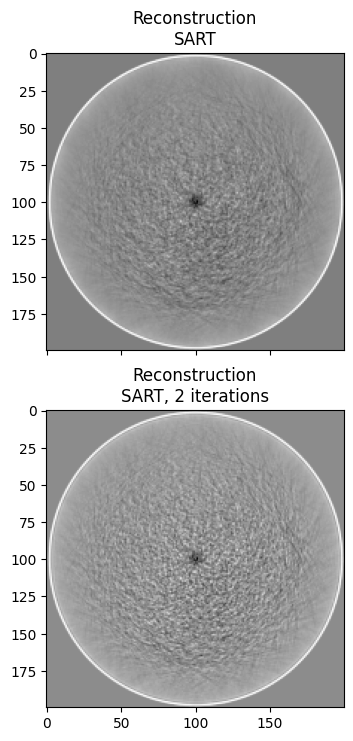

' reconstruction_sart2_denoised = denoise_nl_means(reconstruction_sart2)\nax[2].set_title("Reconstruction\nSART, 2 iterations, De-noised")\nax[2].imshow(reconstruction_sart2_denoised, cmap=plt.cm.Greys_r) '

In [ ]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)

fig, axes = plt.subplots(2, 1, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)

ax[1].set_title("Reconstruction\nSART, 2 iterations")
ax[1].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)
plt.show()
#De-noised
''' reconstruction_sart2_denoised = denoise_nl_means(reconstruction_sart2)
ax[2].set_title("Reconstruction\nSART, 2 iterations, De-noised")
ax[2].imshow(reconstruction_sart2_denoised, cmap=plt.cm.Greys_r) '''

In [ ]:
from skimage import restoration
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, calibrate_denoiser)
from skimage.metrics import peak_signal_noise_ratio as psnr

estimated noise standard deviation = 2.2252907364220653


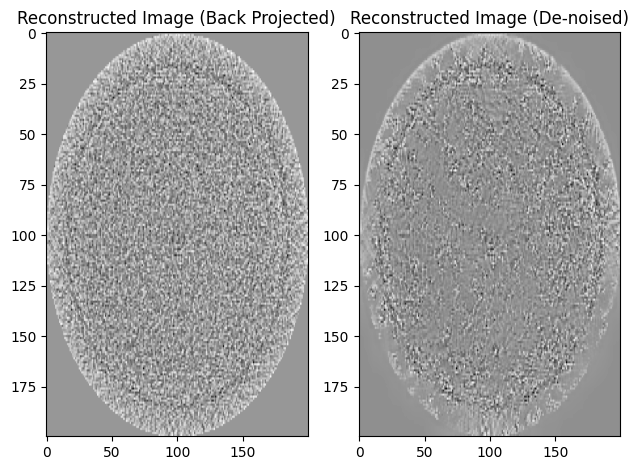

In [ ]:
sinogram = []
for i in range (0,180):
  sinogram.append(image_stack[i][0]) #Take the ith row from each image in stack to create sinogram
sinogram = np.array(sinogram).T
theta = np.arange(0,180,1)
reconstructed_image_fbp = iradon(sinogram, theta=theta, circle=True,filter_name='ramp')
sigma_est = np.mean(restoration.estimate_sigma(reconstructed_image_fbp))
print(f'estimated noise standard deviation = {sigma_est}')
reconstruction_image_denoised = denoise_nl_means(reconstructed_image_fbp,fast_mode=True,sigma= sigma_est)
#reconstructed_image_denoised = denoise_nl_means(reconstructed_image_fbp, patch_size=5, patch_distance=7)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Reconstructed Image (Back Projected)")
ax1.imshow(reconstructed_image_fbp,cmap=plt.cm.Greys_r, aspect = 'auto')
ax2.set_title("Reconstructed Image (De-noised)")
ax2.imshow(reconstruction_image_denoised,cmap=plt.cm.Greys_r, aspect = 'auto')
fig.tight_layout()
plt.show()

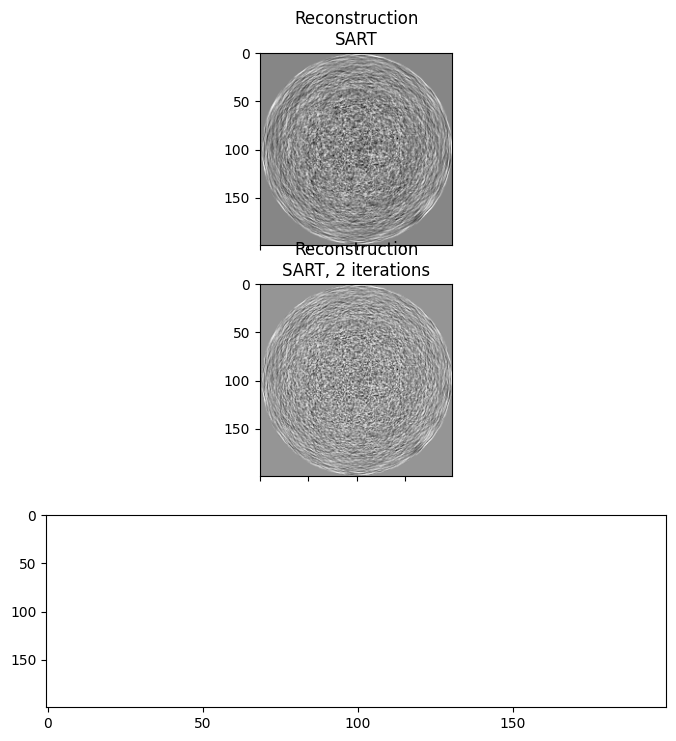

estimated noise standard deviation = 1.3318573509893727


In [ ]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)

fig, axes = plt.subplots(3, 1, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)

ax[1].set_title("Reconstruction\nSART, 2 iterations")
ax[1].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)
plt.show()
#De-noised
sigma_est = np.mean(restoration.estimate_sigma(reconstruction_sart2))
print(f'estimated noise standard deviation = {sigma_est}')
reconstruction_sart2_denoised = denoise_nl_means(reconstruction_sart2,fast_mode=True,sigma= sigma_est)
ax[2].set_title("Reconstruction\nSART, 2 iterations, De-noised")
ax[2].imshow(reconstruction_sart2_denoised, cmap=plt.cm.Greys_r)
plt.show()

Estimated Gaussian noise standard deviation = 2.1383645465548278


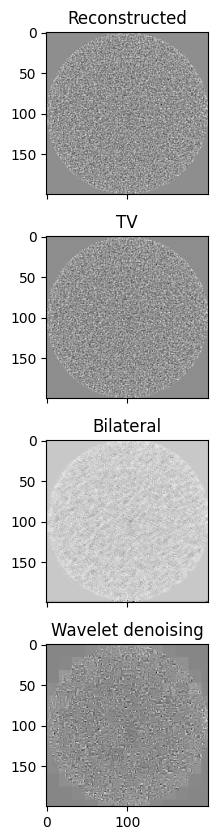

In [ ]:
sinogram = []
for i in range (0,180):
  sinogram.append(image_stack[i][0]) #Take the ith row from each image in stack to create sinogram
sinogram = np.array(sinogram).T
theta = np.arange(0,180,1)
reconstructed_image_fbp = iradon(sinogram, theta=theta, circle=True,filter_name='ramp')

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(reconstructed_image_fbp, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')
fig, axes = plt.subplots(4, 1, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(reconstructed_image_fbp,cmap=plt.cm.Greys_r)
ax[0].set_title('Reconstructed')
ax[1].imshow(denoise_tv_chambolle(reconstructed_image_fbp),cmap=plt.cm.Greys_r)
ax[1].set_title('TV')
ax[2].imshow(denoise_bilateral(reconstructed_image_fbp),cmap=plt.cm.Greys_r)
ax[2].set_title('Bilateral')
ax[3].imshow(denoise_wavelet(reconstructed_image_fbp),cmap=plt.cm.Greys_r)
ax[3].set_title('Wavelet denoising')

''' ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, channel_axis=-1))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15,
                channel_axis=-1))
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True,
                                rescale_sigma=True))
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original') '''

fig.tight_layout()

plt.show()

Text(0.5, 1.0, 'TV_bregman')

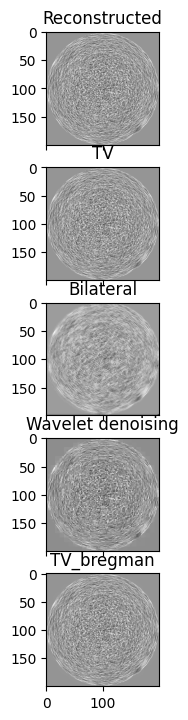

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(reconstruction_sart2,cmap=plt.cm.Greys_r)
ax[0].set_title('Reconstructed')
ax[1].imshow(denoise_tv_chambolle(reconstruction_sart2),cmap=plt.cm.Greys_r)
ax[1].set_title('TV')
ax[2].imshow(denoise_bilateral(reconstruction_sart2),cmap=plt.cm.Greys_r)
ax[2].set_title('Bilateral')
ax[3].imshow(denoise_wavelet(reconstruction_sart2),cmap=plt.cm.Greys_r)
ax[3].set_title('Wavelet denoising')
ax[4].imshow(denoise_tv_bregman(reconstruction_sart2),cmap=plt.cm.Greys_r)
ax[4].set_title('TV_bregman')

estimated noise standard deviation = 7.47924556318728e-43


Text(0.5, 1.0, 'FBP+ de-noise nl_means + SART (2 Iterations) + de-noise TV')

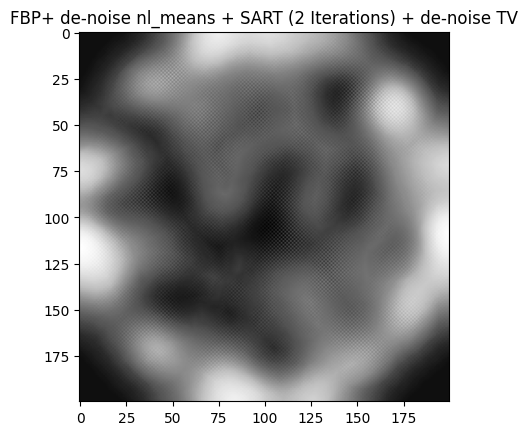

In [ ]:
sinogram = []
for i in range (0,180):
  sinogram.append(image_stack[i][0]) #Take the ith row from each image in stack to create sinogram
sinogram = np.array(sinogram).T
theta = np.arange(0,180,1)
reconstructed_image_fbp = iradon(sinogram, theta=theta, circle=True,filter_name='ramp')
sigma_est = np.mean(restoration.estimate_sigma(reconstructed_image_fbp))
print(f'estimated noise standard deviation = {sigma_est}')
reconstruction_image_denoised = denoise_nl_means(reconstructed_image_fbp,fast_mode=True,sigma= sigma_est)
reconstruction_sart = iradon_sart(sinogram, theta=theta,image=reconstruction_image_denoised)
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart)
reconstruction_sart2_denoised = denoise_tv_chambolle(reconstruction_sart2)
plt.imshow(reconstruction_sart2_denoised,cmap=plt.cm.Greys_r)

plt.title("FBP+ de-noise nl_means + SART (2 Iterations) + de-noise TV")

Calibrating De-noiser

Minimum self-supervised loss TV: 0.0000


Text(0.5, 1.0, 'FBP+ de-noise nl_means + SART (2 Iterations) + de-noise TV (calibrated)')

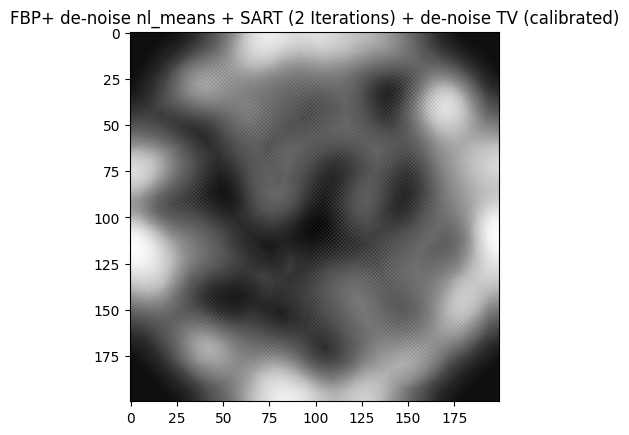

In [ ]:
parameter_ranges_tv = {'weight': np.arange(0.01, 0.3, 0.02)}
_, (parameters_tested_tv, losses_tv) = calibrate_denoiser(
                                    reconstruction_sart2,
                                    denoise_tv_chambolle,
                                    denoise_parameters=parameter_ranges_tv,
                                    extra_output=True)
print(f'Minimum self-supervised loss TV: {np.min(losses_tv):.4f}')

best_parameters_tv = parameters_tested_tv[np.argmin(losses_tv)]
''' denoised_calibrated_tv = denoise_invariant(reconstruction_sart2, denoise_tv_chambolle,
                                           denoiser_kwargs=best_parameters_tv) '''
denoised_default_tv = denoise_tv_chambolle(reconstruction_sart2, **best_parameters_tv)
plt.imshow(denoised_default_tv,cmap=plt.cm.Greys_r)
plt.title("FBP+ de-noise nl_means + SART (2 Iterations) + de-noise TV (calibrated)")

In [ ]:
np.max(denoised_default_tv)

3.6e-43